**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [31]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread, imwrite
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D

np.random.seed(6)
lbl_cmap = random_label_cmap()

# Data

We assume that data has already been downloaded in via notebook [1_data.ipynb](1_data.ipynb).  
We now load images from the sub-folder `test` that have not been used during training.

In [10]:
X = sorted(glob(r"D:\Sian\OneDrive - King's College London\Documents\Pragya\Tif_EMMand EMM-N\*.tif"))
X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

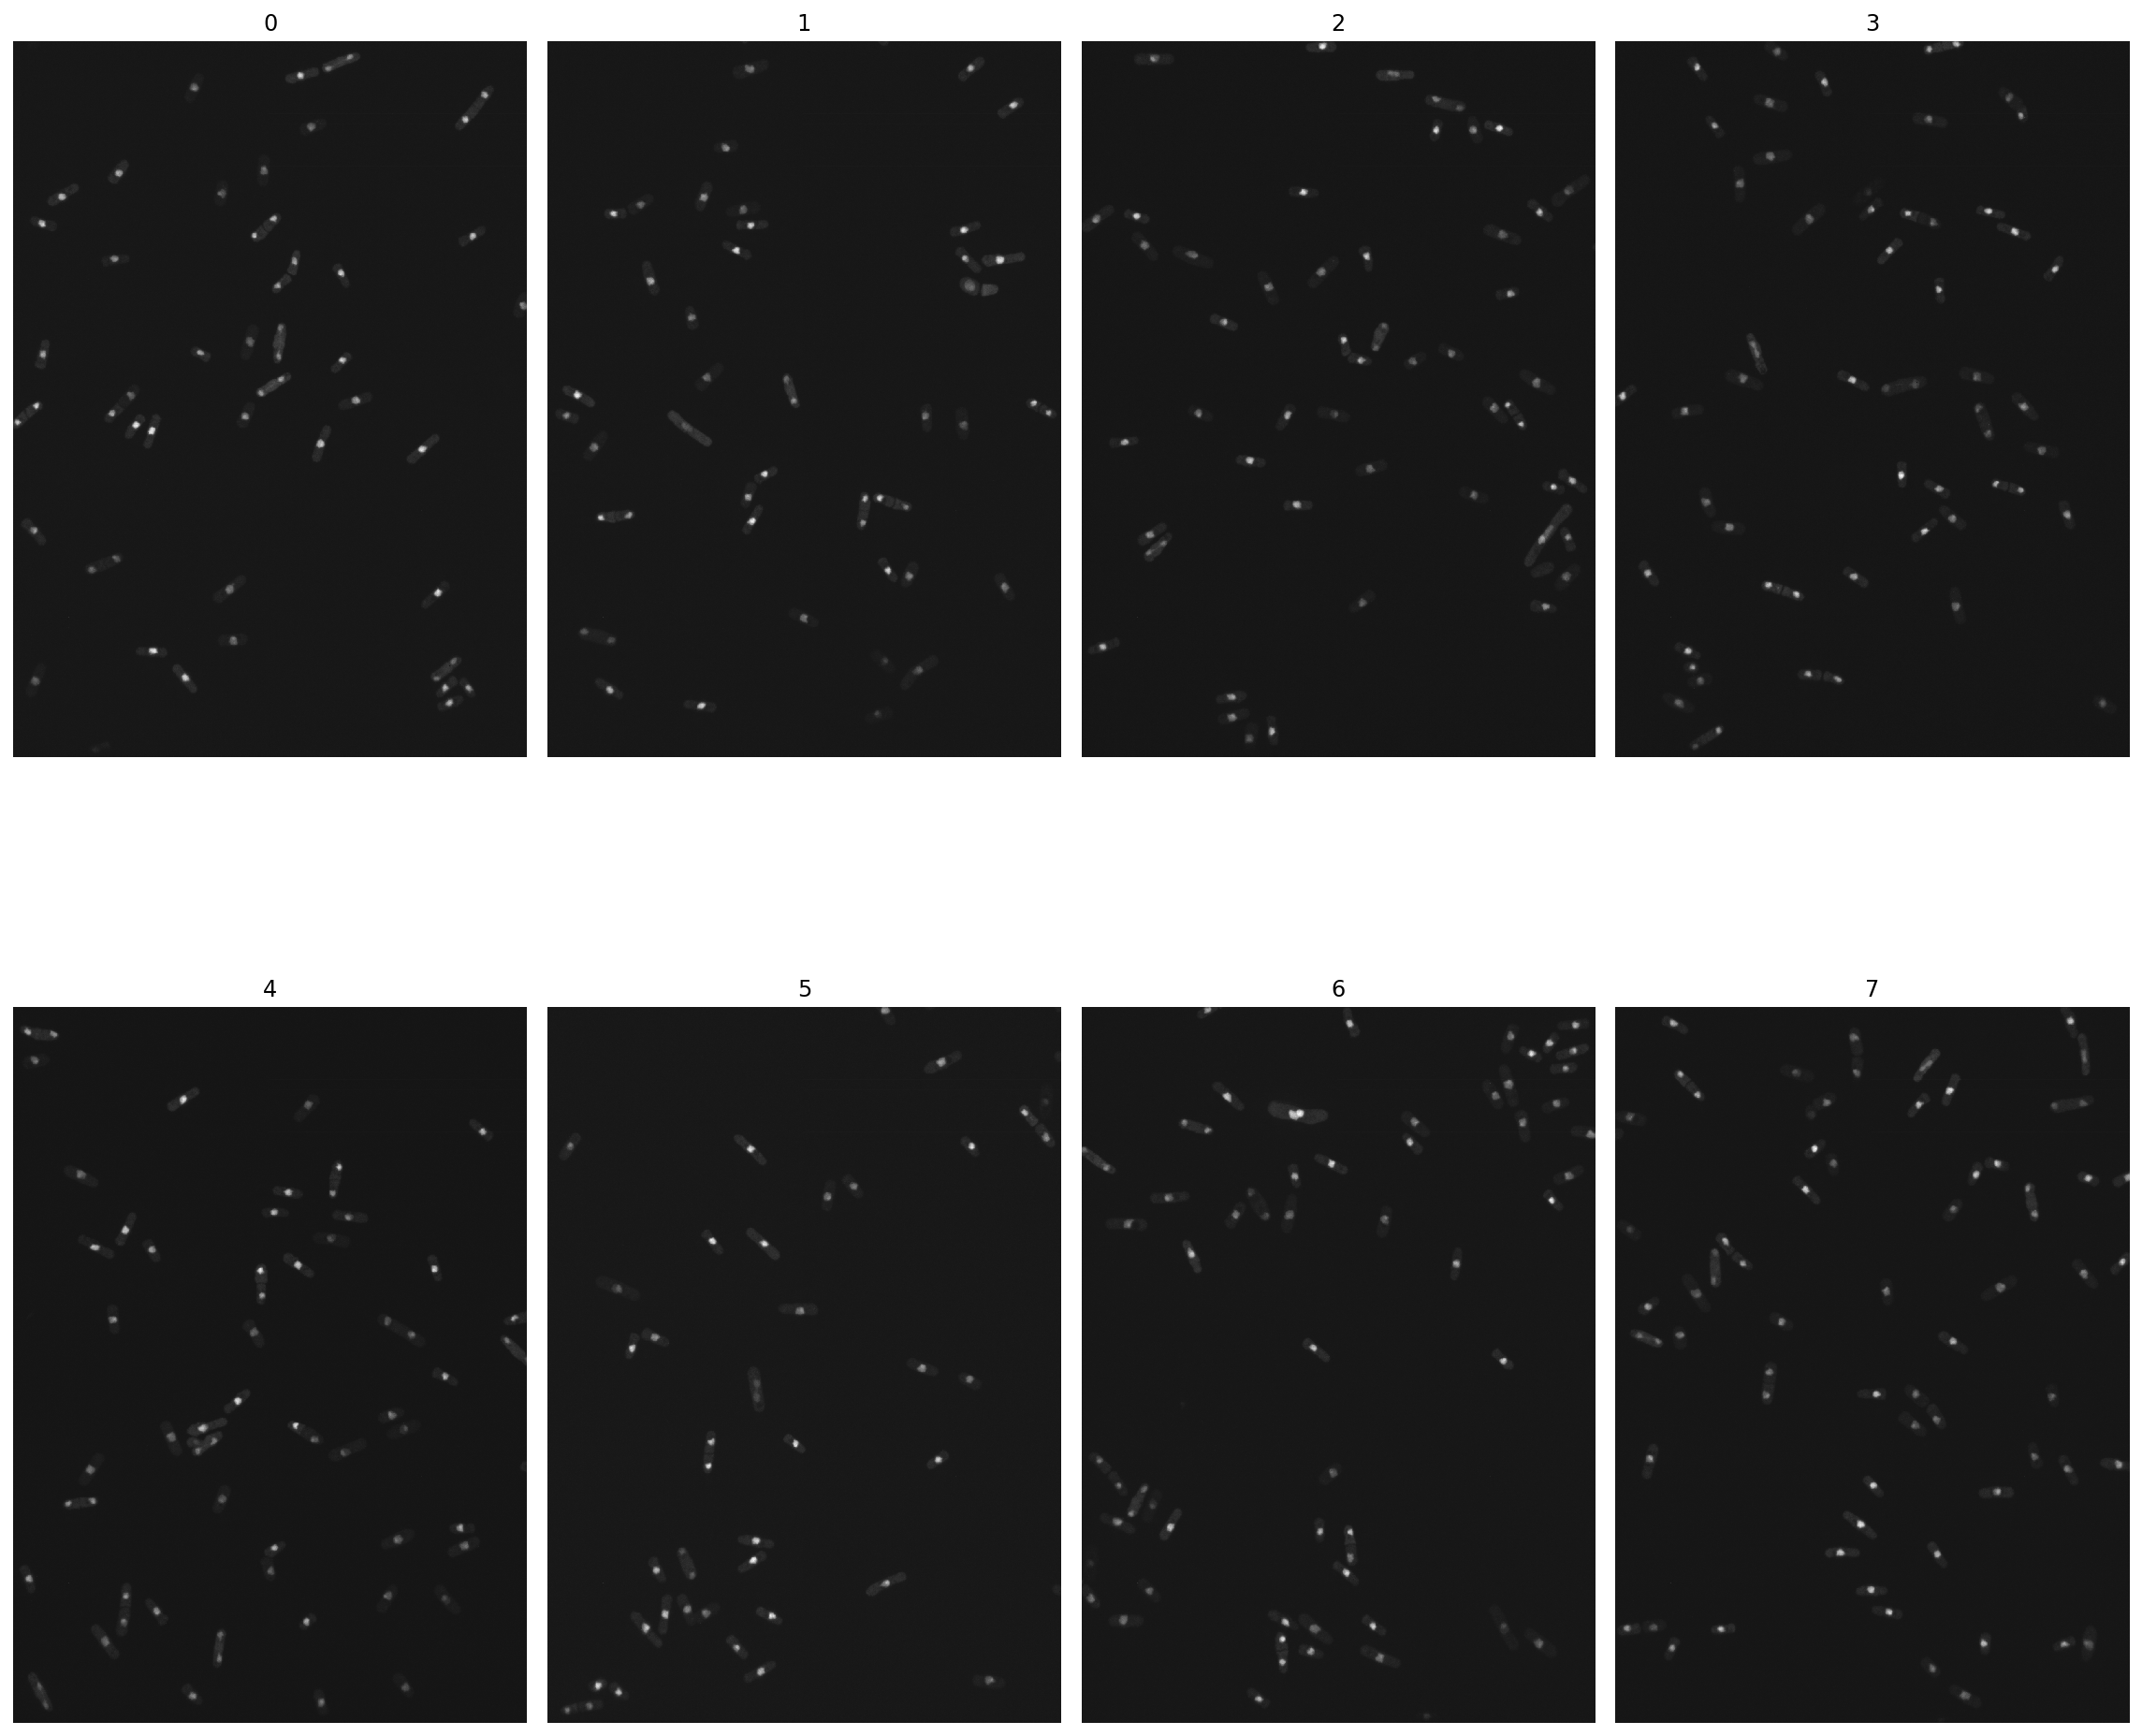

In [11]:
# show all test images
if True:
    fig, ax = plt.subplots(2,4, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

# Load trained model

If you trained your own StarDist model (and optimized its thresholds) via notebook [2_training.ipynb](2_training.ipynb), then please set `demo_model = False` below.

In [12]:
model = StarDist2D(None, name='stardist_60x_AV1200', basedir='models')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.587421, nms_thresh=0.3.


## Prediction

Make sure to normalize the input image beforehand or supply a `normalizer` to the prediction function.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

In [19]:
Y = [] # empty list to store label predictions
for i in range(len(X)):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)
    # labels has 0 as background and a different integer for each nucleus
    labels_01 = np.zeros(labels.shape) # make a blank image of the correct shape
    
    for j in range(labels.shape[0]):
        for i in range(labels.shape[1]):
            if labels[j, i] > 0:
                labels_01[j, i] = 1
    
    Y.append(labels_01)

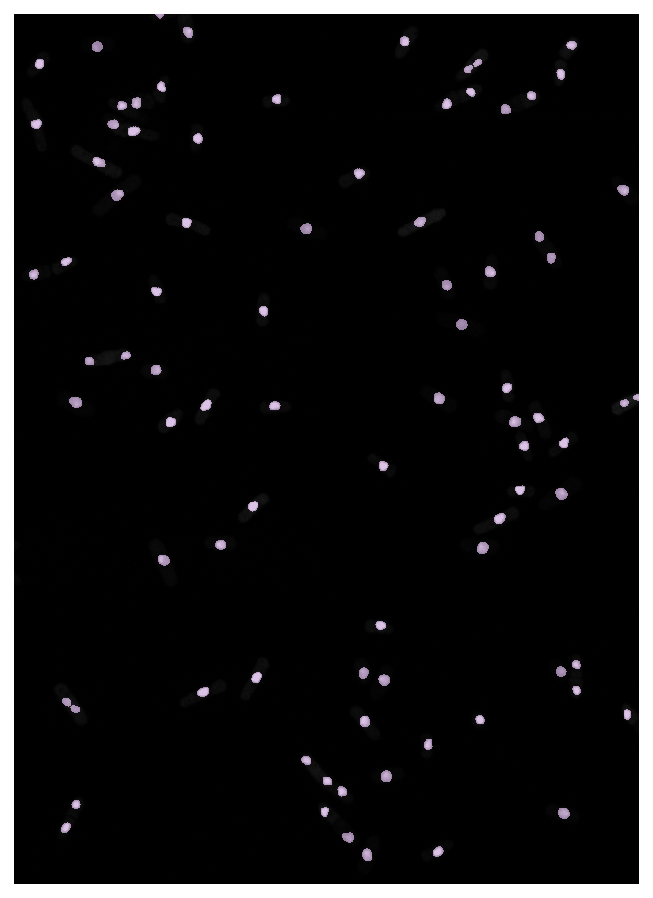

In [20]:
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels_01, cmap=lbl_cmap, alpha=0.7)
plt.axis('off');

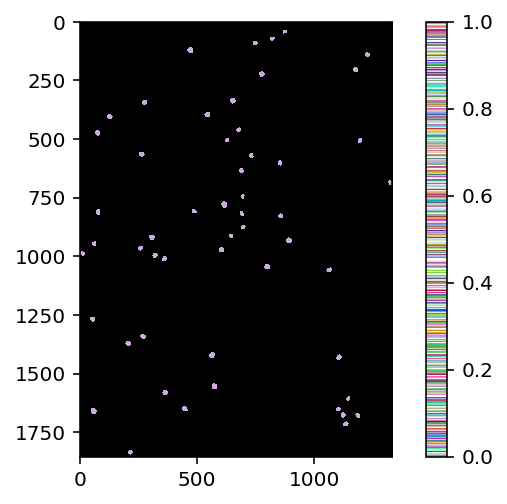

In [21]:
plt.imshow(Y[0], cmap=lbl_cmap)
plt.colorbar()

## Save predictions

Uncomment the lines in the following cell if you want to save the example image and the predictions to disk.  
See [this notebook](../other2D/export_imagej_rois.ipynb) for more details on how to export ImageJ ROIs.

In [7]:
# save_tiff_imagej_compatible('example_image.tif', img, axes='YX')
save_path = r"D:\Sian\OneDrive - King's College London\Documents\Pragya\Tif_EMMandEMM-N_labels"
for i in range(len(Y)):
    save_tiff_imagej_compatible('example_labels.tif', labels, axes='YX')
# export_imagej_rois('example_rois.zip', details['coord'])

### Read, predict, binarise and save images 

In [45]:
import os

# make sure we have correct image shapes etc
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)  

# load trained stardist model
model = StarDist2D(None, name='stardist_60x_AV1200', basedir='models')

# path for max-intensity projected images
images_path = r"D:\Sian\OneDrive - King's College London\Documents\Pragya\YES_Fixed_091024"

# create save folder which has _labels at the end
save_path = f"{images_path}_labels"

# if the folder doesn't already exist, create it
if not os.path.exists(save_path):
    os.mkdir(save_path)

# list of original image files
file_list = os.listdir(images_path)

# loop through tifs
for file in file_list:

    # check file is a tif
    if not file.endswith('.tif'):
        continue
        
    print(f'Running predictions on {file}')
    
    x = imread(os.path.join(images_path, file)) # read in image data from file
    print(x.shape)
    
    # see how many images (i.e. channels) are in file
    # single images
    if len(x.shape) == 2:
        img = normalize(x, 1,99.8, axis=axis_norm) # normalize raw image
        labels, details = model.predict_instances(img) # predict nuclei

        # labels has 0 as background and a different integer for each nucleus
        labels_01 = np.zeros(labels.shape) # make a blank image of the correct shape

        # binarise labels
        for j in range(labels.shape[0]):
            for i in range(labels.shape[1]):
                if labels[j, i] > 0:
                    labels_01[j, i] = 1
    
    # multiple images
    else:
        y = []
        for k in range(len(x)):
            img = normalize(x[k], 1,99.8, axis=axis_norm) # normalize raw image
            labels, details = model.predict_instances(img) # predict nuclei

            # labels has 0 as background and a different integer for each nucleus
            labels_01 = np.zeros(labels.shape) # make a blank image of the correct shape

            # binarise labels
            for j in range(labels.shape[0]):
                for i in range(labels.shape[1]):
                    if labels[j, i] > 0:
                        labels_01[j, i] = 1
            
            y.append(labels_01)
            
        labels_01 = np.asarray(y)
    
    # save binarised labels
    save_name = os.path.join(save_path, file)
    
    # converting to 16-bit integer, making sure pixel size is correct as well when saving
    imwrite(save_name, labels_01.astype('uint16'),
            imagej=True,
           resolution=(1.0 / 0.1083333, 1.0 / 0.1083333),
        metadata={'unit': 'um'})
    

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.587421, nms_thresh=0.3.
Running predictions on 60x_60pc_100ms_zstack001.tif
(1854, 1332)
Running predictions on 60x_60pc_100ms_zstack002.tif
(1854, 1332)
Running predictions on 60x_60pc_100ms_zstack003.tif
(1854, 1332)
Running predictions on 60x_60pc_100ms_zstack004.tif
(1854, 1332)
Running predictions on 60x_60pc_100ms_zstack005.tif
(1854, 1332)
Running predictions on 60x_60pc_100ms_zstack006.tif
(1854, 1332)
Running predictions on 60x_60pc_100ms_zstack007.tif
(1854, 1332)
Running predictions on 60x_60pc_100ms_zstack008.tif
(1854, 1332)
Running predictions on 60x_60pc_100ms_zstack009.tif
(1854, 1332)
Running predictions on 60x_60pc_100ms_zstack010.tif
(1854, 1332)
Running predictions on 60x_60pc_100ms_zstack011.tif
(1854, 1332)
Running predictions on 60x_60pc_100ms_zstack012.tif
(1854, 1332)
Running predictions on 60x_60pc_100ms_zstack013.tif
(1854, 1332)
Runn

# Example results

In [7]:
def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

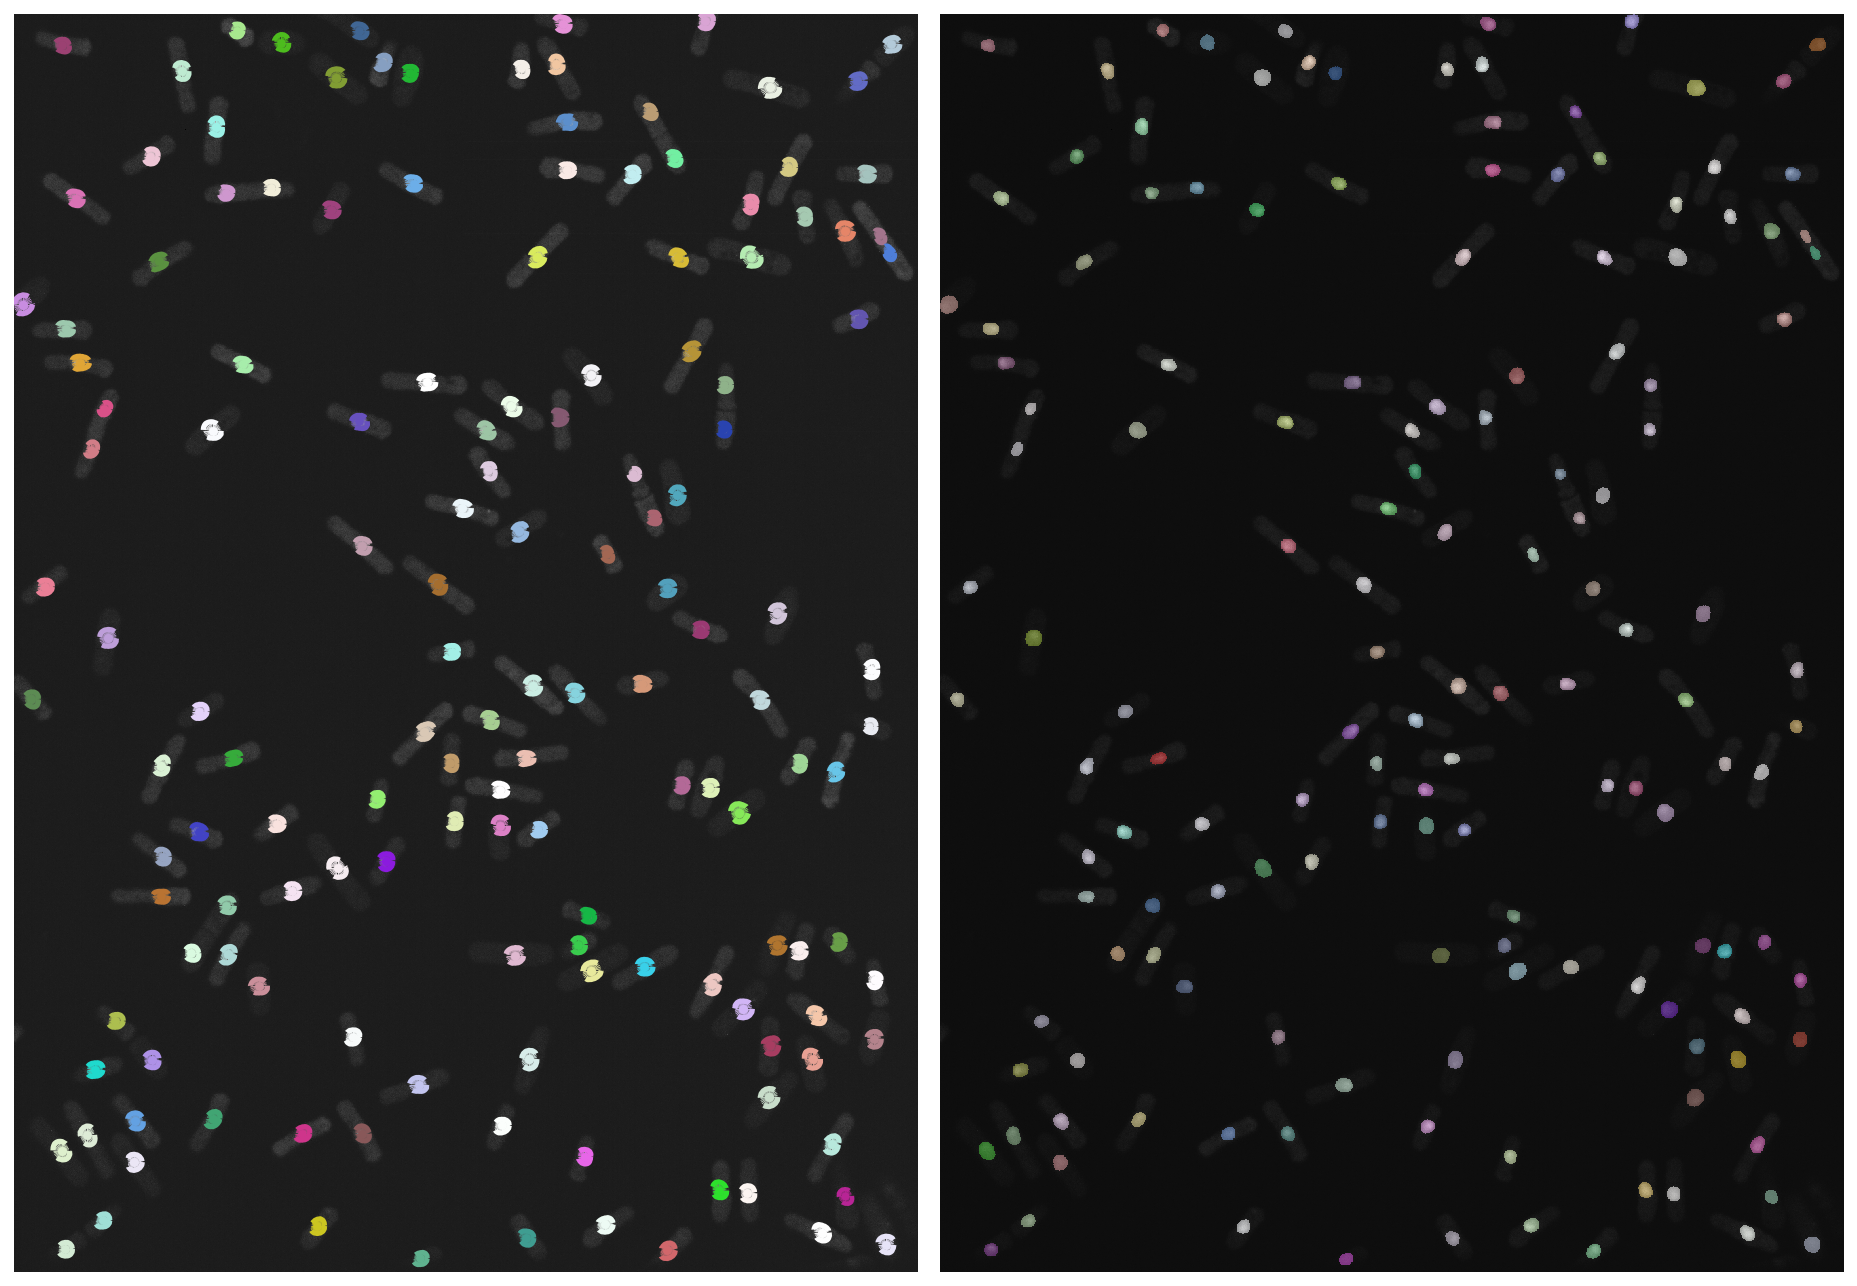

In [8]:
example(model, 16)

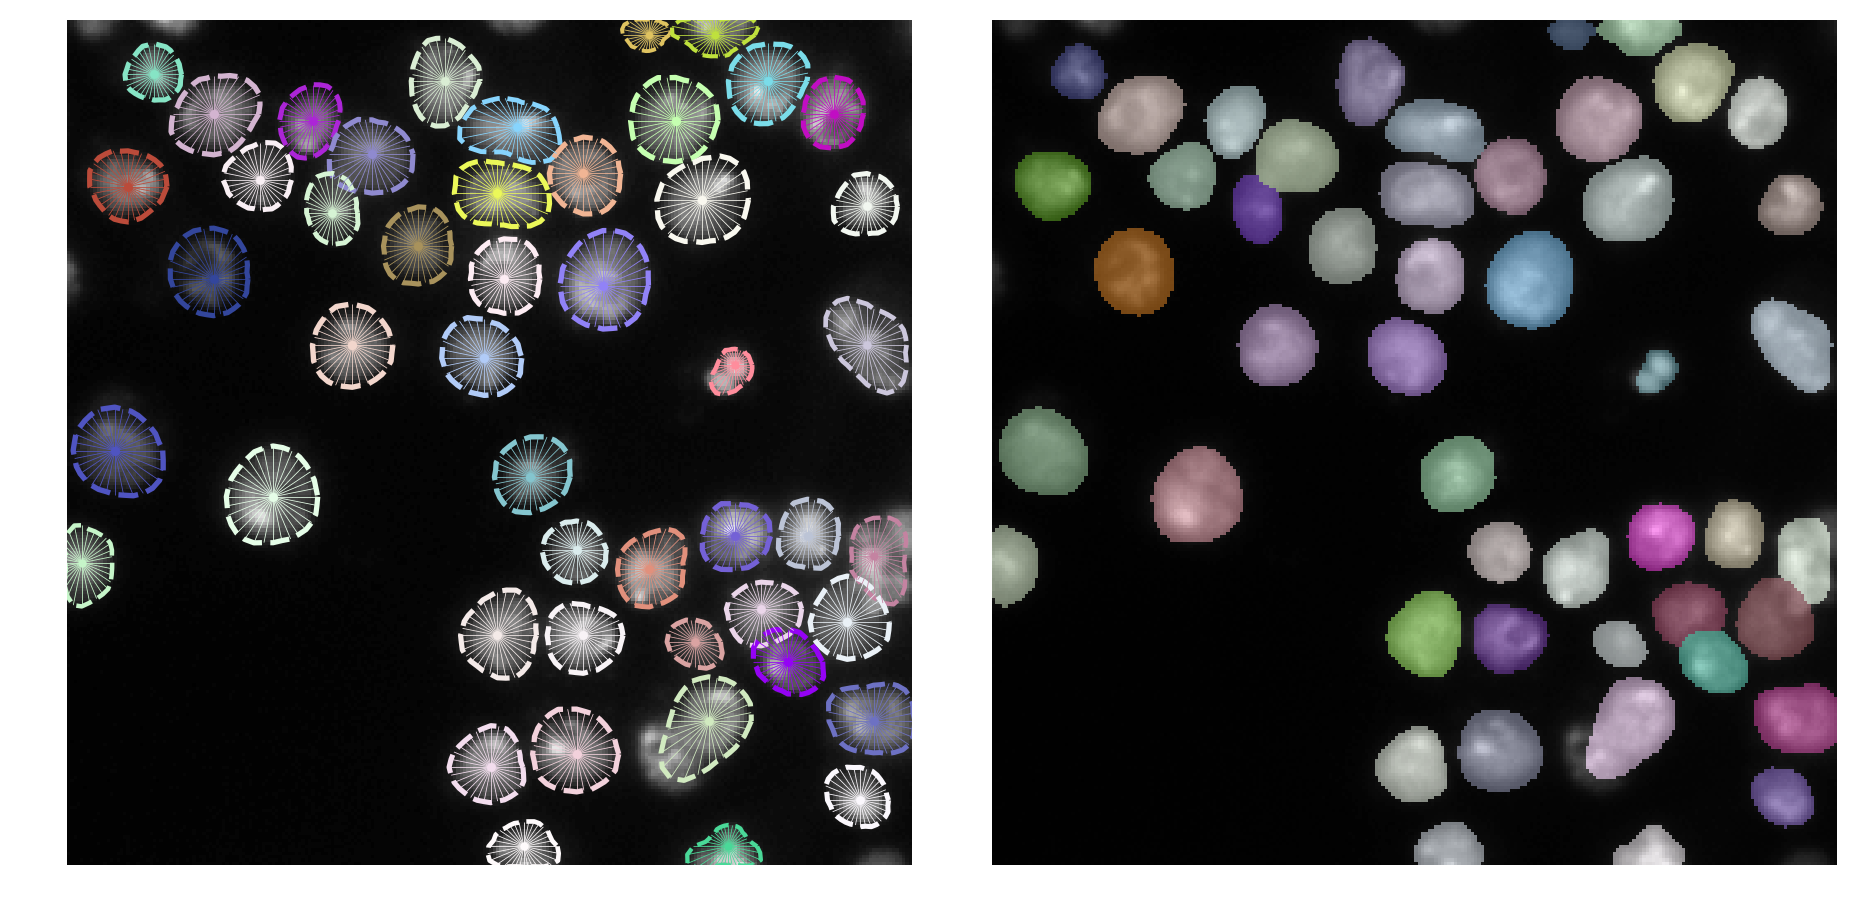

In [10]:
example(model, 1)

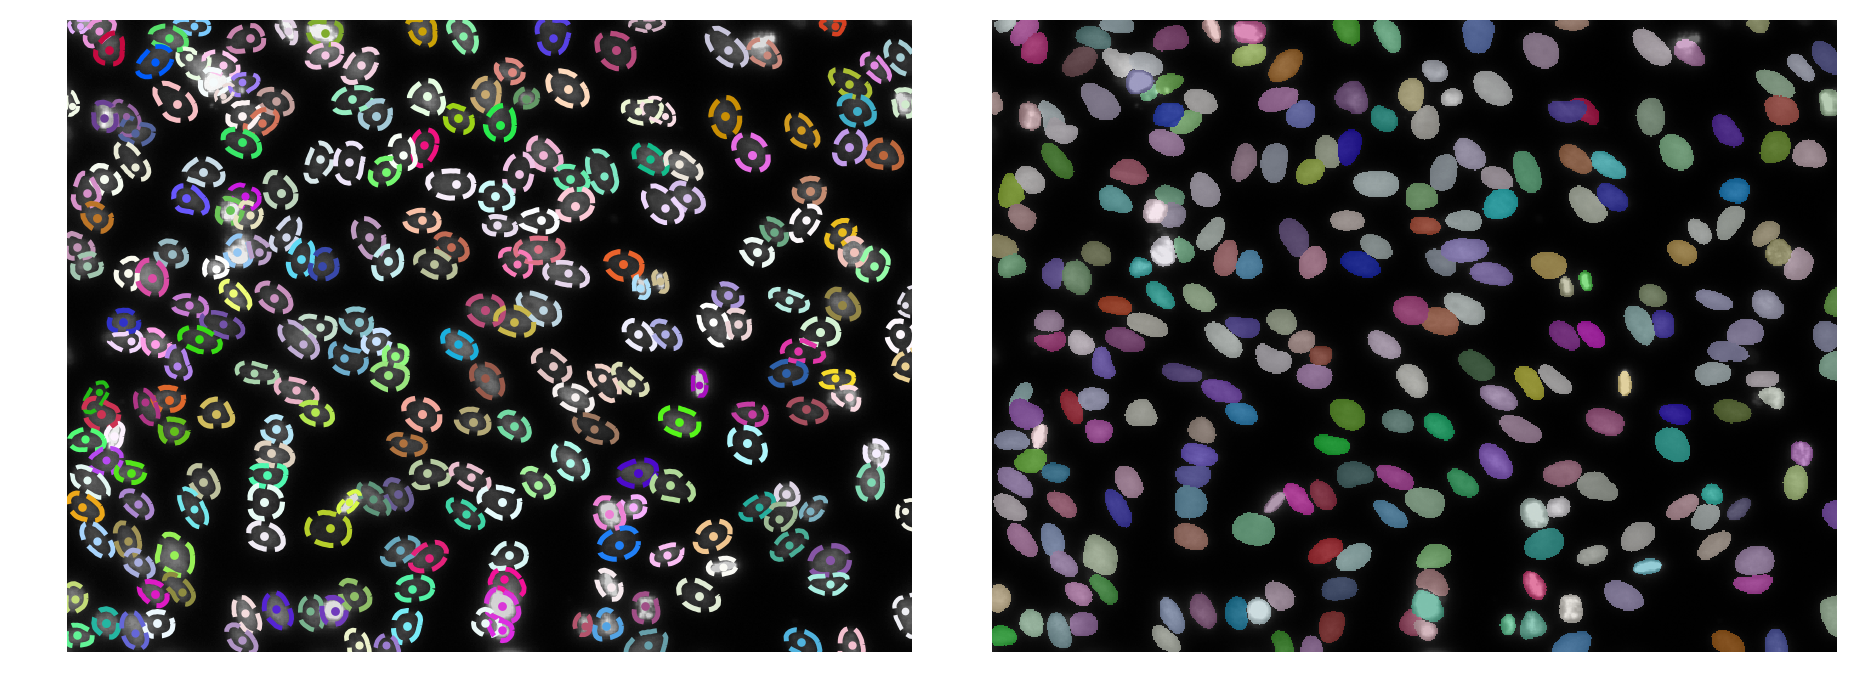

In [11]:
example(model, 15, False)

# Model from paper

In [12]:
model_paper = StarDist2D.from_pretrained('2D_paper_dsb2018')

Found model '2D_paper_dsb2018' for 'StarDist2D'.
Loading network weights from 'weights_last.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.417819, nms_thresh=0.5.


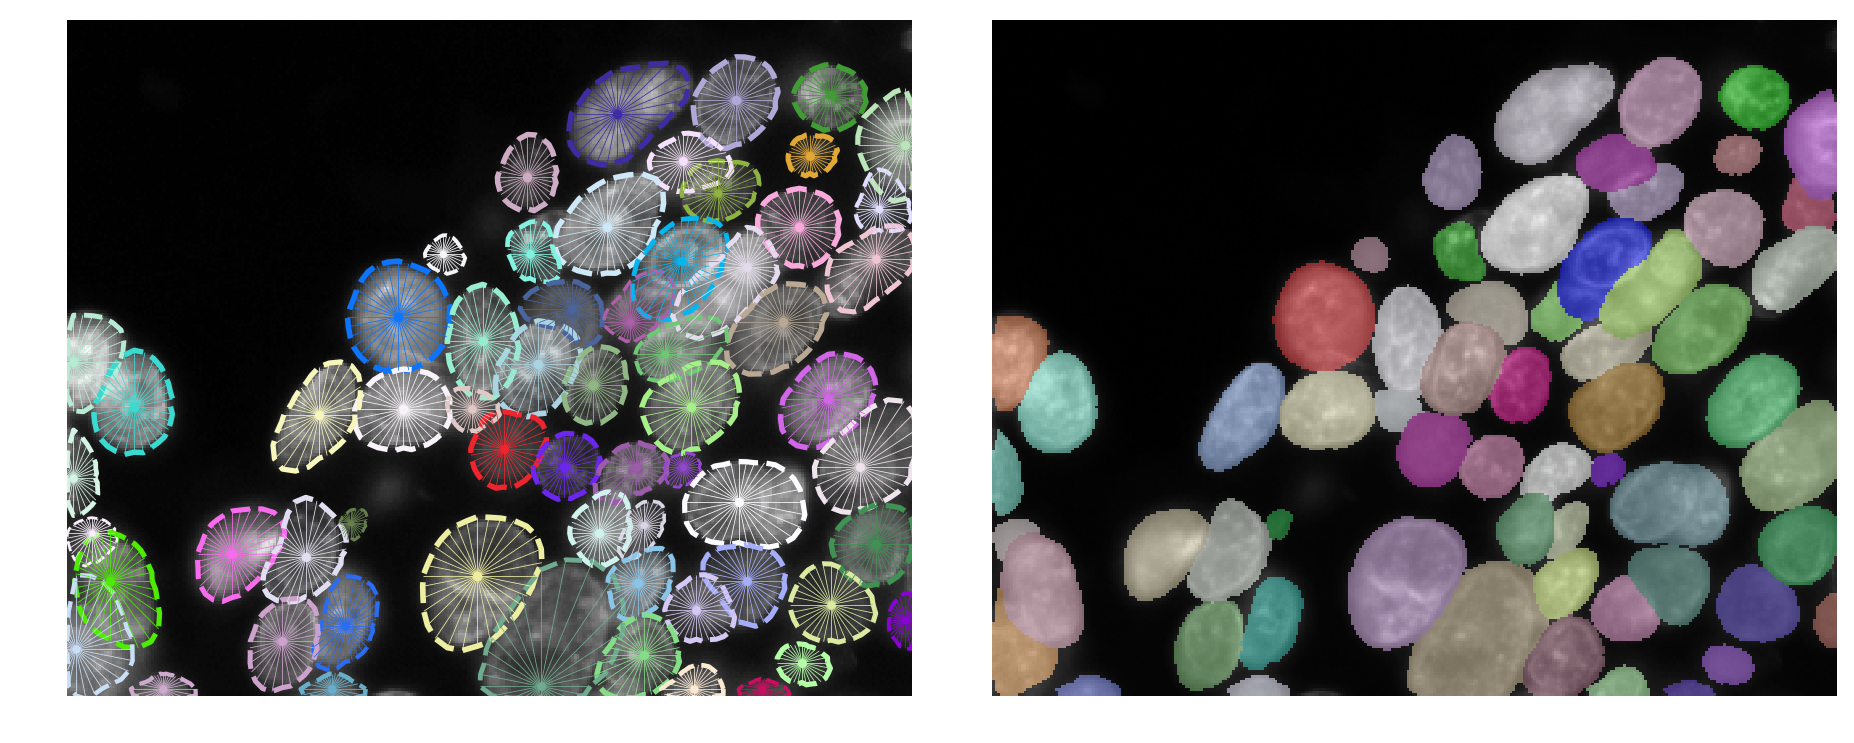

In [13]:
example(model_paper, 29)

# Versatile model

Try this model first if you have images that look similar to the training data in this example.

In [14]:
model_versatile = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


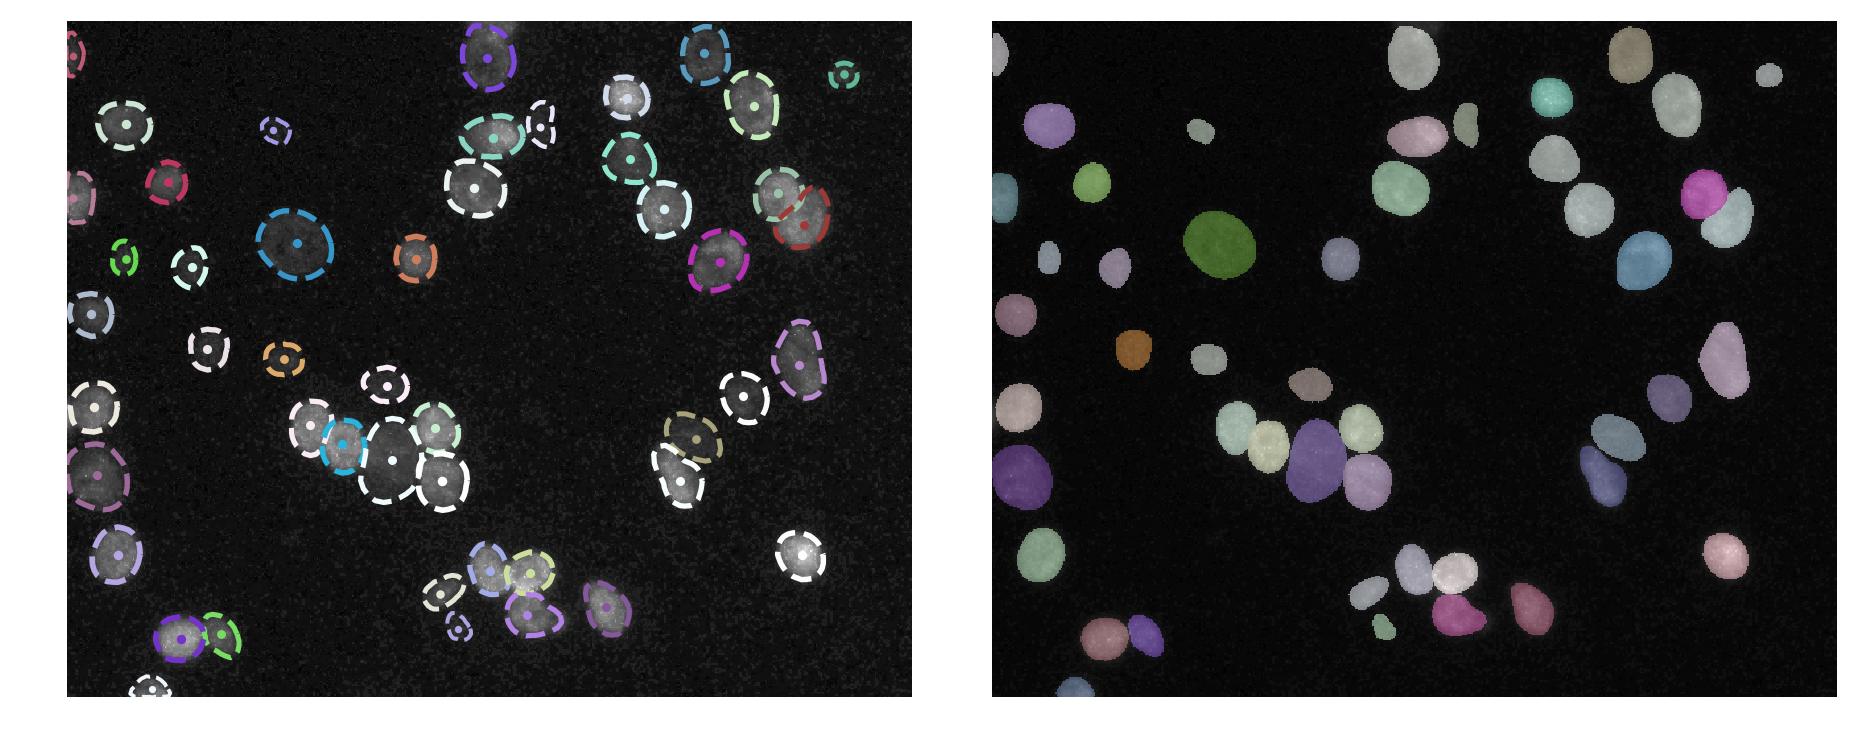

In [15]:
example(model_versatile, 30, False)

Show all available pretrained models:

In [16]:
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
